## Observations

Month is not a useful variable. Try Quarter.
Best result so far is decision tree with df[['Exterior Wall', 'Fixtures', 'Neighborhood', 'Story Height', 'Assessment Ratio', 'Building Grade', 'Quarter']]

Lots of outliers here, try RandomForest

With XGBoost, got down to 40.9

## Next step: incorporate data from full dataframe.

Possibly: average fixtures per house in the neighborhood?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')
import matplotlib.dates as mdates

In [2]:
df1=pd.read_csv('nashville_20190827200234.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

C:\Users\alehe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
df1.columns

Index(['Assessment Classification*', 'Assessment Improvement',
       'Assessment Land', 'Assessment Total', 'Assessment Year', 'Baths',
       'Beds2', 'Building Condition', 'Building Condition2', 'Building Grade',
       'Building Grade2', 'Building Type', 'Building Type2', 'Current Owner',
       'Deed Reference', 'Exterior Wall', 'Exterior Wall2', 'Fixtures',
       'Fixtures2', 'Foundation Type', 'Foundation Type2', 'Frame Type',
       'Half Bath', 'Half Bath2', 'Improvement Value', 'Land Area',
       'Land Value', 'Location', 'Mailing Address', 'Map & Parcel',
       'Most Recent Sale Date', 'Most Recent Sale Price', 'Neighborhood',
       'Number of Living Units', 'Roof Cover', 'Rooms', 'Rooms2',
       'Square Footage', 'Square Footage2', 'Story Height', 'Story Height2',
       'Tax District', 'Total Appraisal Value', 'Year Built', 'Year Built2',
       'Zone', 'Parcel ID', 'Land Use', 'Property Address', 'Suite/ Condo   #',
       'Property City', 'Sale Date', 'Sale Price', 

In [14]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Testing the averaged assessment ratio idea.
df['Assessment Ratio'] = df['Assessment Land Improved'] / df['Total Appraisal Value Improved']
nbhdratio=df.groupby('Neighborhood')['Assessment Ratio'].mean().to_frame().rename(columns={'Assessment Ratio':'Nbhd Ratio'})
df=df.merge(nbhdratio, how='left', left_on = 'Neighborhood',right_index=True)
df['Month']= df['Sale Date'].dt.month
df['Quarter'] = df['Sale Date'].dt.quarter
df['Year'] = df['Sale Date'].dt.year
#df = df[(df.Neighborhood != '9527') & (df.Neighborhood != '9026')]
df['Building Grade']= df['Building Grade'].str.replace(r'\w\w\w', '').dropna()
df=df[df.PPS <= 1150]

In [18]:
TYPEDICT = {'HIGHRISE APT': 'HRISE', 'APARTMENT': 'CONDO', 'HRISE CONDO': 'HRISE',
            'RESD CONDO': 'CONDO', 'RW SING FAM': 'SINGLE FAM', 'SINGLE FAM': 'SINGLE FAM',
            'RZ SING FAM': 'SINGLE FAM', 'RH SING FAM': 'SINGLE FAM',
            'RY SING FAM': 'SINGLE FAM', 'MODULAR HOME': 'SINGLE FAM',
            'SING FAM': 'SINGLE FAM', 'RESD TRIPLEX': 'PLEX', 'RESD QUADPLX': 'PLEX',
            'R1 DUPLEX': 'PLEX', 'RES DUPLEX': 'PLEX', 'LODGE/FRAT\'L': 'THIRD',
            'CHURCH': 'THIRD', 'HEALTH CLUB': 'COMM', 'GROCERY/SMKT': 'COMM',
            'RETAIL/SHPG': 'COMM', 'DAYCARE': 'COMM', 'MARKET': 'COMM',
            'REST/BAR': 'COMM', 'OFFICE': 'OFFICE', 'WAREHOUSE': 'INDUSTRIAL',
            'EQUIP SHED': 'INDUSTRIAL', 'SERV GARAGE': 'INDUSTRIAL', 'TRUCK TERM': 'INDUSTRIAL',
            'ZERO LOT': 'VACANT', 'CAR WASH': 'COMM', 'MED OFC': 'OFFICE',
            'LAUNDRY': 'COMM', 'AUDITORIUM': 'THIRD', 'BANK': 'COMM', 'BOWLING': 'COMM',
            'BUSINESS CTR': 'COMM', 'CINEMA': 'COMM', 'CLUB/UNION': "THIRD",
            "COMM GRNHSE": "INDUSTRIAL", 'WHSE RETAIL': 'COMM', 'ENG/RESEARCH': 'OFFICE',
            'COUNTRY CLUB': 'THIRD', 'DEPT STORE': 'COMM', 'TENNIS': 'THIRD',
            'WALKUP APT': 'CONDO', 'DRUG STORE': 'COMM', 'DISC STORE': 'COMM',
            'ELDERLY HSG': 'CONDO', "FUNERAL HM": "THIRD", 'SALES SHOWRM': 'COMM',
            'LUMBER': 'INDUSTRIAL', 'MANF PLANT': 'INDUSTRIAL', 'MAINT HANGER': 'INDUSTRIAL',
            'MOTEL': 'COMM', 'MINI-LUBE': 'INDUSTRIAL', 'MINI-WAREHSE': 'INDUSTRIAL',
            'FAST FOOD': 'COMM', 'HOTEL': 'COMM', 'NURSING HOME': 'CONDO', "PARK'G GAR": 'COMM',
            'SERV STATION': 'COMM', 'INDOOR WP': 'COMM', 'HOSPITAL': 'THIRD', 'T-HANGER': 'INDUSTRIAL'
            }

df['Building Type Custom']=df['Building Type'].map(lambda x: TYPEDICT[x] if (x != '' and not pd.isnull(x)) else None)

In [20]:
df['Building Type Custom'].value_counts()

SINGLE FAM    37989
CONDO         13024
VACANT         1229
PLEX           1116
HRISE           952
COMM             21
THIRD            19
OFFICE            7
INDUSTRIAL        2
Name: Building Type Custom, dtype: int64

In [248]:
df.nsmallest(15, 'PPS')[['Location', 'Zone', 'Sale Price', 'PPS', 'Square Footage Improved', 'Building Type Custom']]

,Location,Zone,Sale Price,PPS,Square Footage Improved,Building Type Custom
176025,690 CANDLESTICK DR,1,49.0,0.027313,1794.0,SINGLE FAM
27056,1203 ALANDEE ST,7,50.0,0.044524,1123.0,SINGLE FAM
191004,5441 CAMELOT RD,2,10000.0,2.211411,4522.0,SINGLE FAM
239278,1013 SUMMERCREST CT,8,10000.0,4.108463,2434.0,SINGLE FAM
138891,64 VALERIA ST,1,5000.0,4.340278,1152.0,SINGLE FAM
117379,31 N HILL ST,1,10001.0,4.857212,2059.0,SINGLE FAM
241961,3703 EZELL RD,8,27500.0,6.202075,4434.0,PLEX
87022,5801 MACKIE PL,3,10000.0,6.635700,1507.0,SINGLE FAM
266262,6582 SUNNYWOOD DR,1,15000.0,6.934813,2163.0,SINGLE FAM
210028,4839 JONQUIL DR,1,30000.0,7.812500,3840.0,SINGLE FAM


In [21]:
df.PPS=df.PPS.replace(np.inf, np.nan)

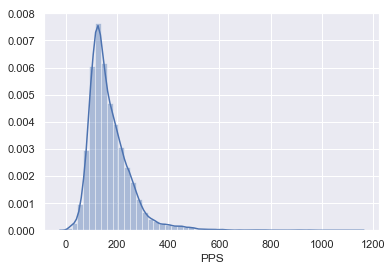

In [250]:
sns.distplot(df['PPS'].dropna())

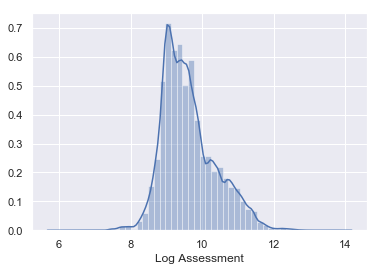

In [22]:
df['Log Assessment']= df['Assessment Land Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Assessment']=df['Log Assessment'].replace(np.inf, np.nan)
sns.distplot(df['Log Assessment'].dropna())

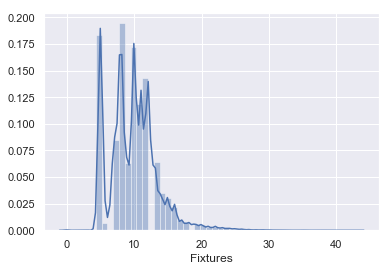

In [43]:
sns.distplot(df['Fixtures'].dropna())

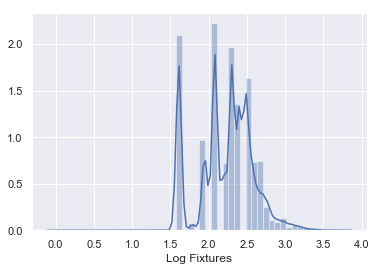

In [23]:
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
sns.distplot(df['Log Fixtures'].dropna())

In [12]:
df['Fixtures'].quantile([.9,.95,.995])

0.900    14.0
0.950    16.0
0.995    24.0
Name: Fixtures, dtype: float64

In [ ]:
#df=df[df['Fixtures']<23]

In [25]:
np.std(df.PPS)

83.41484485663136

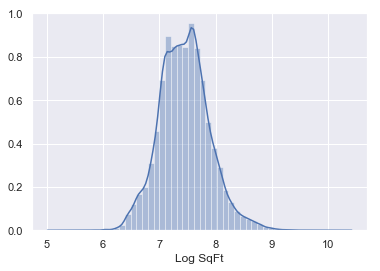

In [24]:
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log SqFt']=df['Log SqFt'].replace(np.inf, np.nan)
sns.distplot(df['Log SqFt'].dropna())

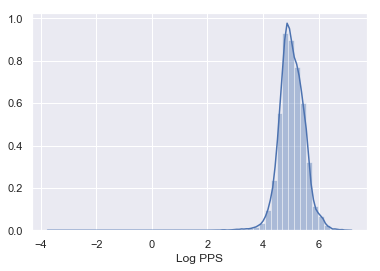

In [26]:
df['Log PPS']= df['PPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log PPS']=df['Log PPS'].replace(np.inf, np.nan)
sns.distplot(df['Log PPS'].dropna())

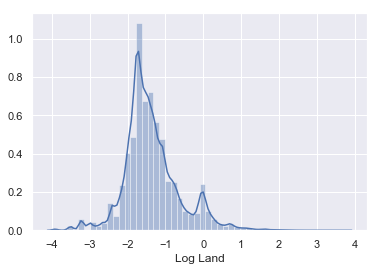

In [27]:
df['Log Land']= df['Land Area Acres'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)

sns.distplot(df['Log Land'].dropna())

In [28]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.model_selection import train_test_split

In [381]:
med = df2['Log Land'].median()

KeyError: 'Log Land'

In [29]:
df.Quarter= df.Quarter.map(lambda x: str(x) if pd.notnull(x) else '')
df.Year= df.Year.map(lambda x: str(x) if pd.notnull(x) else '')

In [72]:
df2 = df[['Exterior Wall','Log SqFt','Log Fixtures','Building Type Custom','Building Grade','Year','Log Assessment','NeighborhoodPPS', 'PPS', 'Quarter']]
# med = df2['Log Land'].median()
# df2['Log Land'].fillna(med, inplace=True)
df2=df2.dropna()

In [74]:
X= pd.get_dummies(df2[['Exterior Wall','Year','NeighborhoodPPS','Log Assessment','Log Fixtures','Building Grade','Building Type Custom','Log SqFt', 'Quarter']])
y=df2['PPS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

In [75]:
print(df.shape)
print(df2.shape)

(54359, 78)
(54242, 10)


In [76]:
from sklearn.dummy import DummyRegressor as DR
model = DR(strategy='median')
dr=model.fit(X_train, y_train)
y_pred= dr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

84.79181923150843


In [77]:
model = DTR()
dtr=model.fit(X_train, y_train)
y_pred= dtr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

46.76169211777424


In [78]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
rfr=model.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

C:\Users\alehe\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


35.884458688904836


In [223]:
from sklearn.model_selection import GridSearchCV
params={}
rfgrid = GridSearchCV(estimator = model,param_grid=params, cv = 3, verbose=2, n_jobs = -1)
rf_r = rfgrid.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


In [225]:
rf_r.best_score_

0.5316834751375379

In [227]:
from sklearn.model_selection import cross_val_score
cross_val_score(estimator=model, X=X, y=y, cv=7, n_jobs=4)

array([0.54473921, 0.62245412, 0.66817821, 0.66147927, 0.57945044,
       0.6063188 , 0.56401164])

In [80]:
from xgboost import XGBRegressor as XGBR

model = XGBR(colsample_bytree=0.4, gamma=0, learning_rate=0.07, 
             max_depth=5, min_child_weight=1.5, n_estimators=700,                                                                    
             reg_alpha=0.75, reg_lambda=0.45, subsample=0.6, seed=42)

xgbr=model.fit(X_train,y_train)
y_predxg=xgbr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_predxg, y_test)**0.5)

33.68024098190987


In [79]:
import lightgbm as lgb
params={}
d_train = lgb.Dataset(X_train, label=y_train)
clf= lgb.train(params,d_train, 500)
y_pred = clf.predict(X_test)
print(MSE(y_pred, y_test)**0.5)

33.62173458392949


In [ ]:
#Best score so far
colsample_bytree=0.4, gamma=0, learning_rate=0.07, 
             max_depth=5, min_child_weight=1.5, n_estimators=2000,                                                                    
             reg_alpha=0.75, reg_lambda=0.45, subsample=0.6, seed=42

### GridSearchCV didn't get as good results as untuned RandomForest.

In [ ]:
# Number of trees in random forest
n_estimators = [100,150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [6,7,8]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]

random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [66]:
from sklearn.model_selection import GridSearchCV
rfgrid = GridSearchCV(estimator = clf, param_grid = params, cv = 5, verbose=2, n_jobs = -1)
# Fit the random search model
rf_r = rfgrid.fit(X_train, y_train)

TypeError: estimator should be an estimator implementing 'fit' method, <lightgbm.basic.Booster object at 0x00000199804EA5F8> was passed

In [ ]:
rfgrid.best_params_

In [ ]:
rfgrid.best_score_ 

In [ ]:
np.exp(rfgrid.best_score_ )

## Examining where it went wrong

In [47]:
copiedxg= X_test.copy()
copiedxg['Actual']= y_test
copiedxg['Predicted']= y_predxg
copiedxg['Difference'] = np.absolute(copiedxg['Actual'] - copiedxg['Predicted'])

In [48]:
copiedxg.nlargest(20,'Difference')

,NeighborhoodPPS,Log Assessment,Log Fixtures,Exterior Wall_BRICK,Exterior Wall_BRICK/FRAME,Exterior Wall_CONC BLK,Exterior Wall_FRAME,Exterior Wall_FRAME/STONE,Exterior Wall_GLASS,Exterior Wall_LOG,...,Building Grade_D,Building Grade_E,Building Grade_X,Quarter_1,Quarter_2,Quarter_3,Quarter_4,Actual,Predicted,Difference
190142,227.515341,11.790557,2.639057,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,919.778700,197.702026,722.076673
130234,305.772035,12.538967,3.332205,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,901.604430,224.686142,676.918288
235871,523.752618,9.695848,1.945910,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,971.843778,358.749664,613.094114
110153,239.413923,9.798127,2.639057,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,723.981900,193.088257,530.893644
144762,159.478142,9.552155,2.079442,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,588.505747,168.407120,420.098627
137087,240.047068,11.109833,2.397895,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,565.307944,220.585190,344.722754
272462,202.829418,9.615805,2.397895,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,525.986224,196.580124,329.406100
119629,323.912969,11.156251,1.609438,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,714.285714,413.228577,301.057138
88967,274.109381,11.042922,2.079442,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,16.166282,288.773804,272.607522
149823,227.515341,11.630709,2.079442,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,547.794118,281.507477,266.286641


In [39]:
copied= X_test.copy()
copied['Actual']= y_test
copied['Predicted']= y_pred
copied['Difference'] = np.absolute(copied['Actual'] - copied['Predicted'])

In [43]:
copied.nlargest(20, 'Difference')[['Actual','Predicted','Difference', 'Log Assessment']]

,Actual,Predicted,Difference,Log Assessment
190142,919.778700,173.645433,746.133267,11.790557
130234,901.604430,233.768751,667.835679,12.538967
235871,971.843778,362.150615,609.693164,9.695848
110153,723.981900,184.964126,539.017775,9.798127
144762,588.505747,175.322895,413.182852,9.552155
272462,525.986224,203.327435,322.658789,9.615805
137087,565.307944,253.991298,311.316646,11.109833
131843,521.881288,240.311803,281.569485,11.225243
88967,16.166282,287.994801,271.828519,11.042922
149823,547.794118,277.448720,270.345397,11.630709


In [49]:
df.loc[151387]

Assessment Classification*                                           RES
Assessment Improvement                                         $486,025 
Assessment Land                                                 $90,000 
Assessment Total                                               $576,025 
Assessment Year                                                     2019
Baths                                                                  4
Beds2                                                                NaN
Building Condition                                               Average
Building Condition2                                                  NaN
Building Grade                                                         X
Building Grade2                                                      NaN
Building Type                                                 SINGLE FAM
Building Type2                                                       NaN
Current Owner                                 3524 

In [145]:
df.loc[110153]

Assessment Classification*                                                       RES
Assessment Improvement                                                      $582,675
Assessment Land                                                              $18,000
Assessment Total                                                            $600,675
Assessment Year                                                                 2019
Baths                                                                              3
Beds2                                                                            NaN
Building Condition                                                           Average
Building Condition2                                                              NaN
Building Grade                                                                     X
Building Grade2                                                                  NaN
Building Type                                                    

### So this house at 690  CANDLESTICK  DR is massively skewing our model because of incorrectly-entered data.
Sale price entered at $49? Real price was 

In [ ]:
sns.distplot(df['Log Assessment'].dropna())
#Need to clean up this column

In [ ]:
df.nlargest(15, 'Assessment Land Improved')

In [26]:
df.nsmallest(15, 'PPS')[['Sale Price', 'Location', 'PPS', 'Square Footage Improved']]

,Sale Price,Location,PPS,Square Footage Improved
191003,10000.0,5441 CAMELOT RD,2.211411,4522.0
239277,10000.0,1013 SUMMERCREST CT,4.108463,2434.0
138890,5000.0,64 VALERIA ST,4.340278,1152.0
117379,10001.0,31 N HILL ST,4.857212,2059.0
241960,27500.0,3703 EZELL RD,6.202075,4434.0
87022,10000.0,5801 MACKIE PL,6.635700,1507.0
266261,15000.0,6582 SUNNYWOOD DR,6.934813,2163.0
210027,30000.0,4839 JONQUIL DR,7.812500,3840.0
244773,28000.0,909 MULBERRY HILL PL,8.158508,3432.0
158356,9000.0,270 TAMPA DR Unit E-1,8.211679,1096.0


In [1]:
import tensorflow as tf

ImportError: Traceback (most recent call last):
  File "C:\Users\alehe\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\alehe\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\alehe\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\alehe\Anaconda3\lib\imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\alehe\Anaconda3\lib\imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.